In [22]:
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

# 데이터 준비

In [2]:
# 패션 mnist 데이터셋 로드
(x_train, y_train), (x_test, y_test) = keras.datasets.fashion_mnist.load_data()

In [3]:
# 이미지 입력시에는 채널에 대한 정보가 있어야 함
x_train.shape

(60000, 28, 28)

In [4]:
# 지금은 Conv2D를 적용하기 위해서 채널 차원을 추가
scaled_train = x_train.reshape(-1, 28, 28, 1) / 255

In [5]:
scaled_train.shape

(60000, 28, 28, 1)

# 합성곱 신경망 모델 구성

1. 합성곱 층으로 이미지에서 특징을 감지
2. 밀집층으로 클래스에 따른 분류 확률을 계산

In [6]:
model = keras.Sequential()

In [7]:
# 합성곱 층 추가
model.add(keras.layers.Conv2D(32, kernel_size = 3, activation = "relu", padding = "same", input_shape = (28, 28, 1)))

C:\Users\sungj\AppData\Roaming\Python\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


- 패션 MNIST 이미지가 (28, 28) 크기에 세임 패딩을 적용, 32개의 필터 사용
    - 출력되는 특성맵의 크기는 (28, 28, 32)

In [8]:
# 풀링층 추가
model.add(keras.layers.MaxPool2D(2))

- (2, 2)크기의 커널을 이용하여 풀링을 적용해서 특성맵의 크기가 절반으로 줄어들고 특성맵의 깊이는 그대로
    - 출력되는 특성맵의 크기는 (14, 14, 32)

In [9]:
# 두 번째 합성곱 - 풀링층 추가
model.add(keras.layers.Conv2D(64, kernel_size = 3, activation = "relu", padding = "same"))
model.add(keras.layers.MaxPool2D(2))

- (14, 14) 크기에 세임 패딩, 64개 필터 사용
    - 출력되는 특성맵의 크기 (14, 14, 64)
- (2, 2) 크기의 커널을 이용하여 풀링
    - 출력되는 특성맵의 크기 (7, 7, 64)

In [11]:
# 3차원 특성맵을 일렬로 펼침
# 10개의 유닛을 가진 밀집층에서 확률을 계산하기 때문에
model.add(keras.layers.Flatten())

In [12]:
# 밀집 은닉층을 하나 더 추가한 후 드롭아웃을 넣어 과대적합을 방지하고 성능을 개선
model.add(keras.layers.Dense(100, activation = "relu"))
model.add(keras.layers.Dropout(0.4))

In [13]:
# 출력층
# 10개의 클래스를 분류하는 다중 분류
model.add(keras.layers.Dense(10, activation = "softmax"))

In [14]:
# 모델 구조 확인
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 28, 28, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 14, 14, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 14, 14, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 7, 7, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 3136)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 100)                 │         313,700 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 100)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,010 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 333,526 (1.27 MB)

 Trainable params: 333,526 (1.27 MB)

 Non-trainable params: 0 (0.00 B)

- 파라미터 개수
    - 첫 번째 합성곱 층
        - 필터의 크기 : (3, 3, 1)
        - 필터의 개수 : 32
        - 3 * 3 * 1 * 32 + 32 = 320
    
    - 두 번째 합성곱 층
        - 필터의 크기 : (3, 3, 32)
        - 필터의 개수 : 64
        - 3 * 3 * 32 * 64 + 64 = 18496
        
    - 밀집 은닉 층
        - Flatten 층에서 (3136,) 크기의 배열이 전달(7 * 7 * 64)
        - 3136 * 100 + 100 - 313700
        
    - 출력층
        - 밀집 은닉 층에서 (100,) 크기의 배열이 전달
        - 100 * 10 + 10 = 1010

# 모델 훈련

- 옵티마이저 : Adam
- 콜백 함수 : ModelCheckpoint, EarlyStopping

In [18]:
checkpoint_cb = keras.callbacks.ModelCheckpoint("./model/best-cnn-model.keras", save_best_only = True)
early_stopping_cb = keras.callbacks.EarlyStopping(patience = 4, restore_best_weights = True)

In [23]:
# 검증데이터 분할
x_sub, x_val, y_sub, y_val = train_test_split(scaled_train, y_train, test_size = 0.2, stratify = y_train, random_state = 12)

In [25]:
model.compile(optimizer = "adam", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])

In [26]:
history = model.fit(x_sub, y_sub, epochs = 20, validation_data = (x_val, y_val), callbacks = [checkpoint_cb, early_stopping_cb])

Epoch 1/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 46s 28ms/step - accuracy: 0.7268 - loss: 0.7595 - val_accuracy: 0.8667 - val_loss: 0.3648
Epoch 2/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.8631 - loss: 0.3829 - val_accuracy: 0.8866 - val_loss: 0.3066
Epoch 3/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 40s 26ms/step - accuracy: 0.8833 - loss: 0.3253 - val_accuracy: 0.8965 - val_loss: 0.2870
Epoch 4/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 43s 28ms/step - accuracy: 0.8956 - loss: 0.2893 - val_accuracy: 0.8968 - val_loss: 0.2789
Epoch 5/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 42s 28ms/step - accuracy: 0.9015 - loss: 0.2671 - val_accuracy: 0.9044 - val_loss: 0.2718
Epoch 6/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 47s 32ms/step - accuracy: 0.9100 - loss: 0.2431 - val_accuracy: 0.9100 - val_loss: 0.2608
Epoch 7/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 55s 37ms/step - accuracy: 0.9171 - loss: 0.2267 - val_accuracy: 0.9098 - val_loss: 0.2488
Epoch 8/20
1500/1500 ━━━━━━━━━━━━━━━━━━━━ 57s 38ms/step - accuracy: 0.9230 -

# 훈련 로그 확인

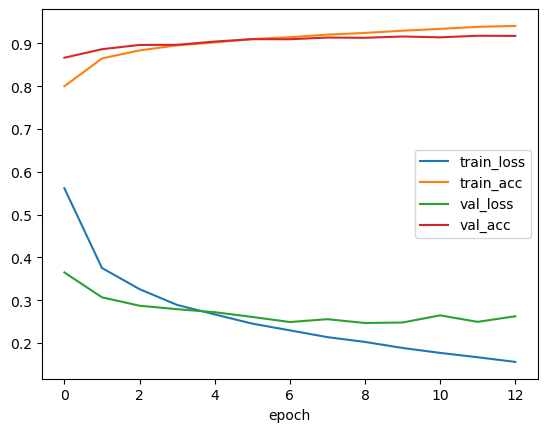

In [27]:
plt.figure()

plt.plot(history.history["loss"], label = "train_loss")
plt.plot(history.history["accuracy"], label = "train_acc")
plt.plot(history.history["val_loss"], label = "val_loss")
plt.plot(history.history["val_accuracy"], label = "val_acc")

plt.legend()
plt.xlabel("epoch")
plt.show()

# 모델 성능 검증

In [29]:
scaled_test = x_test.reshape(-1, 28, 28, 1) / 255

In [32]:
model.evaluate(scaled_test, y_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - accuracy: 0.9137 - loss: 0.2718


[0.2561567723751068, 0.9115999937057495]

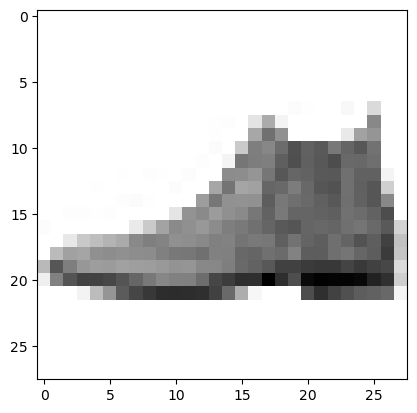

In [31]:
# 데이터 시각화
plt.imshow(scaled_test[0].reshape(28, 28), cmap = "gray_r")
plt.show()

In [33]:
preds = model.predict(scaled_test[[0]])
print(preds)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 123ms/step
[[6.21754781e-09 2.56055194e-11 4.04090407e-11 3.82447719e-12
  1.51159976e-12 1.09081375e-05 2.12902584e-10 1.97896530e-04
  4.54510278e-08 9.99791205e-01]]


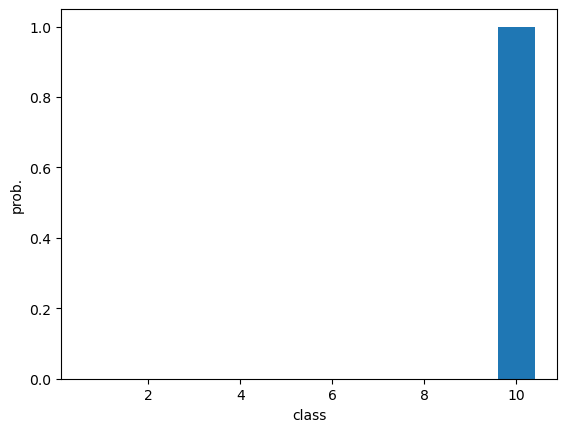

In [34]:
plt.figure()

plt.bar(range(1, 11), preds[0])

plt.xlabel("class")
plt.ylabel("prob.")
plt.show()

In [35]:
# 레이블 리스트
classes = ["티셔츠", "바지", "스웨터", "드레스", "코트", "샌달", "셔츠", "스니커즈", "가방", "앵클 부츠"]

In [38]:
classes[np.argmax(preds)]

'앵클 부츠'

In [39]:
classes[y_test[0]]

'앵클 부츠'